In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import math
import statsmodels.api as sm
from collections import OrderedDict 
from scipy import stats
import seaborn as sns
import plotly.express as px
import seaborn as sns

import matplotlib as mpl
#mpl.rcParams['mathtext.fontset'] = 'stix'
#mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.fontset'] = 'stixsans'
mpl.rcParams['font.family'] = 'sans-serif'

In [14]:
colors={'lightgrey':'#bcc4cd',
        'darkgrey':'#566573',
       'myorange':'#e95c25',
       'myblue':'#4392f1',
       'mygreen':'#00a878'}

def f_fraction(x):
    v = x['gender'].value_counts()
    if v.sum()<2:
        return(np.nan)
    try: 
        f = v['female']/(v['male']+v['female'])
    except:
        f = np.nan
    return(f)

def m_fraction(x):
    v = x['gender'].value_counts()
    if v.sum()<2:
        return(np.nan)
    try: 
        f = v['male']/(v['male']+v['female'])
    except:
        f = np.nan
    return(f)

def f_number(x):
    v = x['gender'].value_counts()
    try: 
        f = v['female']
        return(f)
    except:
        return(0)

def m_number(x):
    v = x['gender'].value_counts()
    try: 
        f = v['male']
        return(f)
    except:
        return(0)

def n_papers(x):
    v = x.drop_duplicates(subset='paper_id')
    return(len(v))


def predicted_frac(df,freq,split_date,gt_max_date, covid='all'):
       
    g = df.groupby(pd.Grouper(key='date',freq=freq))
    n = g.apply(f_fraction)[:gt_max_date]

    if len(n[:split_date].dropna())<7 or len(n[split_date:gt_max_date].dropna())<7:
        return(np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)
    n = n.interpolate(limit_direction='both', limit_area='inside', limit=2)
    periods = len(n[split_date:gt_max_date])-1
    Y_pre = n.loc[:split_date]
    X_pre = range(0,len(Y_pre))
    X_pre = sm.add_constant(X_pre)
    results_pre = sm.OLS(Y_pre,X_pre).fit()
    if periods==1:
        periods=2
    x1n = np.linspace(X_pre.max()+1,X_pre.max()+periods, periods)
    Xnew = sm.add_constant(x1n)
    
    p_value = results_pre.pvalues['x1']
    r2 = results_pre.rsquared
    coef = results_pre.params['x1']

    predictions = results_pre.get_prediction(Xnew).summary_frame(alpha=0.05)
    expected = np.mean(predictions['mean'])
    pred_err = np.mean(predictions['mean_se'])
    

    
    if covid==True:
        g2 = df[df['is_covid']==True].groupby(pd.Grouper(key='date',freq=freq))
        n_cov = g2.apply(f_fraction)[:gt_max_date]
        if len(n_cov.loc[split_date:gt_max_date].dropna())<7:
            return(expected, np.nan, pred_err, np.nan, np.nan, np.nan, np.nan)

    if covid==False:
        g2 = df[df['is_covid']==False].groupby(pd.Grouper(key='date',freq=freq))
        n_cov = g2.apply(f_fraction)[:gt_max_date]
        if len(n_cov.loc[split_date:gt_max_date].dropna())<7:
            return(expected, np.nan, pred_err, np.nan, np.nan, np.nan, np.nan)
    
    if covid=='all':
        real = np.mean(n.loc[split_date:gt_max_date])
        real_err = np.std(n.loc[split_date:gt_max_date])/len(n.loc[split_date:gt_max_date])**(1/2)
    else:
        real = np.mean(n_cov.loc[split_date:gt_max_date])
        real_err = np.std(n_cov.loc[split_date:gt_max_date])/len(n_cov.loc[split_date:gt_max_date])**(1/2)
    
    #err = (expected - np.mean(predictions['obs_ci_lower'])) + np.std(n.loc[split_date:gt_max_date])/len(n.loc[split_date:gt_max_date])**(1/2)
    #pred_err = expected - np.mean(predictions['mean_ci_lower'])
    return(expected, real, pred_err, real_err, p_value, r2, coef)

def gender_diff_frac(df,freq,split_date,gt_max_date,covid):
    expected, real, pred_err, real_err, p_value, r2, coef =  predicted_frac(df,freq,split_date,gt_max_date, covid)
    return(expected, real, pred_err, real_err, p_value, r2, coef)

def get_inc(df,freq,split_date,gt_max_date,gender, num_papers=False):
    g = df.groupby(pd.Grouper(key='date',freq=freq))
    
    if num_papers==True:
        fractions = g.apply(n_papers)[:gt_max_date]    
    else:
        if gender=='f':
            fractions = g.apply(f_number)[:gt_max_date]
        if gender=='m':
            fractions = g.apply(m_number)[:gt_max_date]
        if gender=='all':
            fractions_f = g.apply(f_number)[:gt_max_date]
            fractions_m = g.apply(m_number)[:gt_max_date]
            fractions = fractions_f + fractions_m
    
    periods = len(fractions[split_date:gt_max_date])-1
    Y_pre = fractions.loc[:split_date]
    X_pre = range(0,len(Y_pre))
    X_pre = sm.add_constant(X_pre)
    results_pre = sm.OLS(Y_pre,X_pre).fit()
    x1n = np.linspace(X_pre.max(),X_pre.max()+periods, periods)
    Xnew = sm.add_constant(x1n)
    predictions = results_pre.get_prediction(Xnew).summary_frame(alpha=0.01)
    expected = np.sum(predictions['mean'])
    real = np.sum(fractions.loc[split_date:])
    real_err = np.std(fractions.loc[split_date:gt_max_date])/len(fractions.loc[split_date:gt_max_date])**(1/2)
    pred_err = np.sum(predictions['mean_se'])
    
    p_value = results_pre.pvalues['x1']
    r2 = results_pre.rsquared
    coef = results_pre.params['x1']
    return(expected, real, pred_err, real_err, p_value, r2, coef)

In [15]:
#d = df_single[df_single['platform']=='Springer']
#c = gender_diff_frac(d,freq,split_date,spn_max_date, covid='all')

In [16]:
freq = 'W'
split_date = "2020-03-15"
gt_max_date = "2020-08-02"
spn_max_date = "2020-05-03"
#spn_max_date = "2020-04-01"

In [17]:
df = pd.read_csv('data/standardized_data.csv', parse_dates = ['date'], low_memory=False)
df = df[df['date']<=gt_max_date]

#fix end date for Springer-Nature journals
sp = df[df['platform']=='Springer']
sp = sp[sp['date']<=spn_max_date]
no_sp = df[df['platform']!='Springer']
df = pd.concat([no_sp,sp])

In [18]:
# remove genders with low probability
df = df[df['probability']>=0.8]

# remove countries that do not appear in COVID period 
df = df[df['country_code'].isin(df[df['date']>=split_date]['country_code'].unique())]

#make a new dataset keeping only first authors
df1 = df[df['order']==1]

#make a dataset keeping only the last authors
d = df.sort_values(by='order', ascending=False)
df_last = d.drop_duplicates(subset='paper_id', keep='first')

#make a dataset only with single author papers
num_authors = df.groupby('paper_id')['order'].max()
single_papers = num_authors[num_authors==1].index.values
df_single = df[df['paper_id'].isin(single_papers)]

### Statistics

In [19]:
print('biorxiv papers: '+str(len(df[df['platform']=='biorXiv']['paper_id'].drop_duplicates())))
print('biorxiv authors: '+str(len(df[df['platform']=='biorXiv']['name'].drop_duplicates())))
print('start date: '+ str(df[df['platform']=='biorXiv']['date'].min()))
print('end date: '+ str(df[df['platform']=='biorXiv']['date'].max()))
print('')
print('medrxiv papers: '+str(len(df[df['platform']=='medrXiv']['paper_id'].drop_duplicates())))
print('medrxiv authors: '+str(len(df[df['platform']=='medrXiv']['name'].drop_duplicates())))
print('start date: '+ str(df[df['platform']=='medrXiv']['date'].min()))
print('end date: '+ str(df[df['platform']=='medrXiv']['date'].max()))
print('')
print('springer papers: '+str(len(df[df['platform']=='Springer']['paper_id'].drop_duplicates())))
print('springer authors: '+str(len(df[df['platform']=='Springer']['name'].drop_duplicates())))
print('start date: '+ str(df[df['platform']=='Springer']['date'].min()))
print('end date: '+ str(df[df['platform']=='Springer']['date'].max()))
print('')
print('Total number of papers: '+str(df['paper_id'].nunique()))
print('Total number of authors: '+str(df['name'].nunique()))
print('Total number of males: '+str(len(df[df['gender']=='male'].drop_duplicates(subset='name'))))
print('Total number of females: '+str(len(df[df['gender']=='female'].drop_duplicates(subset='name'))))
print('')
print('Proportion of solo papers: ' + str(len(df_single.drop_duplicates('paper_id'))/len(df.drop_duplicates('paper_id'))))

biorxiv papers: 51171
biorxiv authors: 225110
start date: 2019-01-01 00:00:00
end date: 2020-08-02 00:00:00

medrxiv papers: 8845
medrxiv authors: 52364
start date: 2019-06-25 00:00:00
end date: 2020-08-02 00:00:00

springer papers: 18947
springer authors: 88575
start date: 2019-01-01 00:00:00
end date: 2020-05-03 00:00:00

Total number of papers: 78950
Total number of authors: 346354
Total number of males: 212812
Total number of females: 133542

Proportion of solo papers: 0.032058264724509185


### Increase of number of authors

Text(0.5, 1.0, 'Authors')

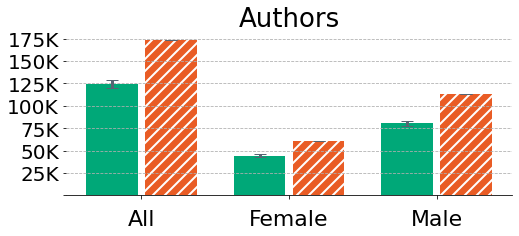

In [20]:
numbers = {}
f = get_inc(df,freq,split_date,gt_max_date,'f', num_papers=False)
m = get_inc(df,freq,split_date,gt_max_date,'m', num_papers=False)
tot = get_inc(df,freq,split_date,gt_max_date,'all', num_papers=False)

v = {'All': {'expected':tot[0], 'real':tot[1], 'expected_err':tot[2], 'real_err':tot[3], 'p':tot[4], 'r2':tot[5], 'coef':tot[6]},
        'Female':{'expected':f[0], 'real':f[1], 'expected_err':f[2], 'real_err':f[3], 'p':f[4], 'r2':f[5], 'coef':f[6]},
        'Male':{'expected':m[0], 'real':m[1], 'expected_err':m[2], 'real_err':m[3], 'p':m[4], 'r2':m[5], 'coef':m[6]}
       }
numbers['authors'] = v
mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(1, figsize=(8, 3))

x = np.array(range(0,len(v.keys())))

expected = [v['expected'] for k,v in v.items()]
ax.bar(x-0.2,expected, width=0.35, 
          align = 'center', color=colors['mygreen'],label='Expected')

real = [v['real'] for k,v in v.items()]
ax.bar(x+0.2,real, width=0.35, 
          align = 'center', color=colors['myorange'], hatch="//", label='Observed')

expected_err = [v['expected_err'] for k,v in v.items()]
ax.errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
real_err = [v['real_err'] for k,v in v.items()]
ax.errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

ax.set_xticks(x)
ax.tick_params(axis='x', which='major', pad=10)
labels = ['All', 'Female', 'Male']
ax.set_xticklabels(labels, fontsize=22)
ax.yaxis.grid(True, which='major', linestyle='--')
ax.set_yticklabels([''] + [str(int(x/1000))+'K' for x in ax.get_yticks()][1:], size = 20)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_title('Authors', fontsize=26)

In [21]:
print('% increase in number of authors')
for k, value in v.items():
    print(str(k)+': '+str((v[k]['real']-v[k]['expected'])*100/v[k]['expected'])+'%')

% increase in number of authors
All: 38.861835338365594%
Female: 36.324410526403895%
Male: 40.25399115546396%


### Increase of number of papers

Text(0.5, 1.0, 'Papers')

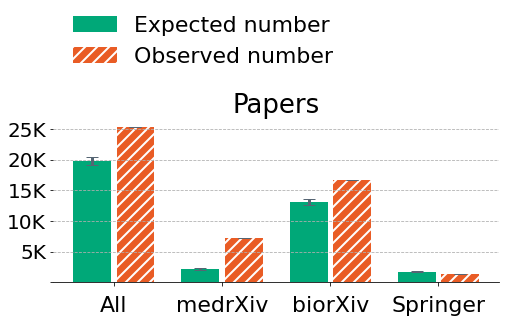

In [22]:
tot = get_inc(df,freq,split_date,gt_max_date,'f', num_papers=True)
med = get_inc(df[df['platform']=='medrXiv'],freq,split_date,gt_max_date,'f', num_papers=True)
bio = get_inc(df[df['platform']=='biorXiv'],freq,split_date,gt_max_date,'m', num_papers=True)
sp = get_inc(df[df['platform']=='Springer'],freq,split_date,spn_max_date,'all', num_papers=True)

v = {'All': {'expected':tot[0], 'real':tot[1], 'expected_err':tot[2], 'real_err':tot[3], 'p':tot[4], 'r2':tot[5], 'coef':tot[6]},
    'medrXiv': {'expected':med[0], 'real':med[1], 'expected_err':med[2], 'real_err':med[3], 'p':med[4], 'r2':med[5], 'coef':med[6]},
        'biorXiv':{'expected':bio[0], 'real':bio[1], 'expected_err':bio[2], 'real_err':bio[3], 'p':bio[4], 'r2':bio[5], 'coef':bio[6]},
        'Springer':{'expected':sp[0], 'real':sp[1], 'expected_err':sp[2], 'real_err':sp[3], 'p':sp[4], 'r2':sp[5], 'coef':sp[6]}
       }
numbers['papers'] = v
mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(1, figsize=(8, 3))

x = np.array(range(0,len(v.keys())))

expected = [v['expected'] for k,v in v.items()]
ax.bar(x-0.2,expected, width=0.35, 
          align = 'center', color=colors['mygreen'],label='Expected number')

real = [v['real'] for k,v in v.items()]
ax.bar(x+0.2,real, width=0.35, 
          align = 'center', color=colors['myorange'], hatch="//", label='Observed number')

expected_err = [v['expected_err'] for k,v in v.items()]
ax.errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
real_err = [v['real_err'] for k,v in v.items()]
ax.errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

ax.set_xticks(x)
ax.tick_params(axis='x', which='major', pad=10)
labels = v.keys()

ax.set_xticklabels(labels, fontsize=22)

ax.yaxis.grid(True, which='major', linestyle='--')
ax.set_yticklabels([''] + [str(int(x/1000))+'K' for x in ax.get_yticks()][1:], size = 20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
ax.set_title('Papers', fontsize=26)

In [23]:
print('% increase in number of papers')
for k, value in v.items():
    print(str(k)+': '+str((v[k]['real']-v[k]['expected'])*100/v[k]['expected'])+'%')

% increase in number of papers
All: 28.33090745040642%
medrXiv: 234.45782329077855%
biorXiv: 26.430264732639255%
Springer: -17.731226662063435%


### Gender differences in general across platforms

In [24]:
types = ['First', 'Last', 'Any', 'Solo']
all_ = {}
for t in types:
    print('All', t)
    if t=='First':
        d = df1
    if t=='Any':
        d = df
    if t=='Last':
        d = df_last
    if t=='Solo':
        d = df_single
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    all_[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}

medrxiv = {}
for t in types:
    print('medrXiv', t)
    if t=='First':
        d = df1[df1['platform']=='medrXiv']
    if t=='Any':
        d = df[df['platform']=='medrXiv']
    if t=='Last':
        d = df_last[df_last['platform']=='medrXiv']
    if t=='Solo':
        d = df_single[df_single['platform']=='medrXiv']
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    medrxiv[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}
    
biorxiv = {}
for t in types:
    print('biorXiv', t)
    if t=='First':
        d = df1[df1['platform']=='biorXiv']
    if t=='Any':
        d = df[df['platform']=='biorXiv']
    if t=='Last':
        d = df_last[df_last['platform']=='biorXiv']
    if t=='Solo':
        d = df_single[df_single['platform']=='biorXiv']
        
    c = gender_diff_frac(d,freq,split_date,gt_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,gt_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,gt_max_date, covid=False)
    
    biorxiv[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}
    
springer = {}
for t in types:
    print('Springer', t)
    if t=='First':
        d = df1[df1['platform']=='Springer']
    if t=='Any':
        d = df[df['platform']=='Springer']
    if t=='Last':
        d = df_last[df_last['platform']=='Springer']
    if t=='Solo':
        d = df_single[df_single['platform']=='Springer']
        
    c = gender_diff_frac(d,freq,split_date,spn_max_date, covid='all')
    cd = gender_diff_frac(d,freq,split_date,spn_max_date, covid=True)
    cn = gender_diff_frac(d,freq,split_date,spn_max_date, covid=False)
    
    springer[t] = {'All':{'expected':c[0],'real':c[1],'expected_err':c[2], 'real_err':c[3], 'p_value':c[4], 'r2':c[5], 'coef':c[6]},
               'COVID':{'expected':cd[0],'real':cd[1],'expected_err':cd[2], 'real_err':cd[3], 'p_value':cd[4], 'r2':cd[5], 'coef':cd[6]},
               'nonCOVID':{'expected':cn[0],'real':cn[1],'expected_err':cn[2], 'real_err':cn[3], 'p_value':cn[4], 'r2':cn[5], 'coef':cn[6]}}
    
    everything = {'Cumulative':all_, 'biorXiv':biorxiv, 'medrXiv':medrxiv, 'Springer-Nature':springer}

All First
All Last
All Any
All Solo
medrXiv First
medrXiv Last
medrXiv Any
medrXiv Solo


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:

invalid value encountered in greater

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:

invalid value encountered in less

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:

invalid value encountered in less_equal

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:

invalid value encountered in greater

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:

invalid value encountered in less

C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:

invalid value encountered in less_equal



biorXiv First
biorXiv Last
biorXiv Any
biorXiv Solo
Springer First
Springer Last
Springer Any
Springer Solo


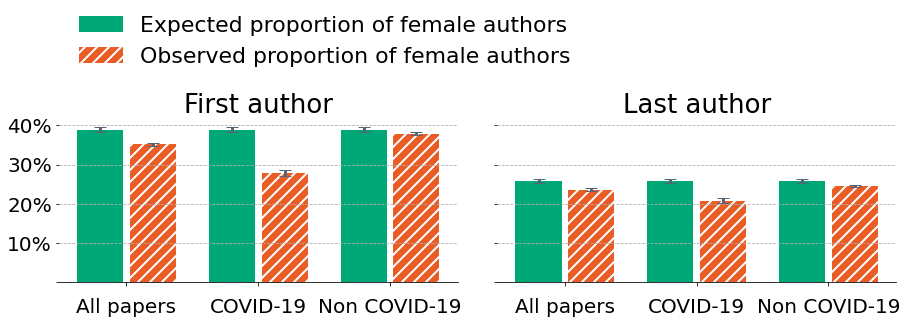

In [25]:
#plot_types = ['Any', 'Solo']
plot_types = ['First', 'Last']
plot_data = {'All publishers':{your_key: all_[your_key] for your_key in plot_types}}

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(len(plot_data), 2, figsize=(15, len(plot_data)*3), sharey=True)

j = 0
for c, v in plot_data['All publishers'].items():

    x = np.array(range(0,len(v.keys())))

    expected = [v['expected']*100 for k,v in v.items()]
    ax[j].bar(x-0.2,expected, width=0.35, 
              align = 'center', color=colors['mygreen'],label='Expected proportion of female authors')

    real = [v['real']*100 for k,v in v.items()]
    ax[j].bar(x+0.2,real, width=0.35, 
              align = 'center', color=colors['myorange'], hatch="//", label='Observed proportion of female authors')

    expected_err = [v['expected_err']*100 for k,v in v.items()]
    ax[j].errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
    real_err = [v['real_err']*100 for k,v in v.items()]
    ax[j].errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

    ax[j].set_xticks(x)
    ax[j].tick_params(axis='x', which='major', pad=12)
    labels = ['All papers', 'COVID-19', 'Non COVID-19']

    ax[j].set_xticklabels(labels, fontsize=20)
    ax[j].set_title(c+' author', fontsize=26)

    ax[j].yaxis.grid(True, which='major', linestyle='--')
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    if j == 0:

        ax[j].legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
        ax[j].set_yticklabels([''] + [str(int(x))+'%' for x in ax[j].get_yticks()][1:], size = 20)

    j+=1
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

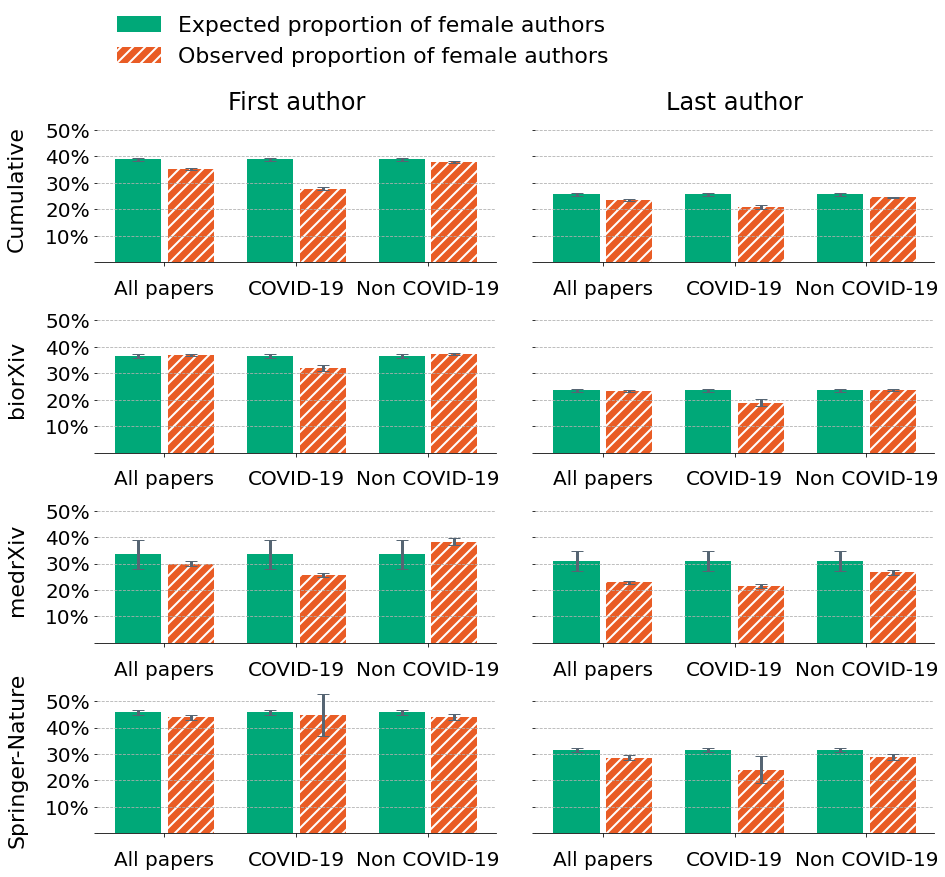

In [26]:
plot_data = {}
for k in everything.keys():
    dict_you_want = {your_key: everything[k][your_key] for your_key in plot_types}
    plot_data[k] = dict_you_want

#plot_data = everything
mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(len(plot_data), 2, figsize=(15, len(plot_data)*3.3), sharey=True)

i = 0
for k, value in plot_data.items():
    j = 0
    for c, v in value.items():

        x = np.array(range(0,len(v.keys())))

        expected = [v['expected']*100 if not math.isnan(v['expected']) else 0 for k,v in v.items()]

        ax[i,j].bar(x-0.2,expected, width=0.35, 
                  align = 'center', color=colors['mygreen'],label='Expected proportion of female authors')

        real = [v['real']*100 if not math.isnan(v['real']) else 0 for k,v in v.items()]

        ax[i,j].bar(x+0.2,real, width=0.35, 
                  align = 'center', color=colors['myorange'], hatch="//", label='Observed proportion of female authors')
        for loc,value in zip(x,real):
            if value==0:
                ax[i,j].text(loc+0.2,4,'N/A',horizontalalignment='center', fontsize=18, color=colors['darkgrey'])
                
        for loc,value in zip(x,expected):
            if value==0:
                ax[i,j].text(loc-0.2,4,'N/A',horizontalalignment='center', fontsize=18, color=colors['darkgrey'])


        expected_err = [v['expected_err']*100 for k,v in v.items()]
        ax[i,j].errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
        real_err = [v['real_err']*100 for k,v in v.items()]
        ax[i,j].errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

        
        ax[i,j].set_xticks(x)
        ax[i,j].tick_params(axis='x', which='major', pad=14)
        labels = ['All papers', 'COVID-19', 'Non COVID-19']
        
        ax[i,j].set_xticklabels(labels, fontsize=20)
        if i==0:
            ax[i,j].set_title(c+' author', fontsize=24)
        
        ax[i,j].yaxis.grid(True, which='major', linestyle='--')
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        if j == 0:
            ax[i,j].set_ylabel(k, fontsize=22, labelpad=18)
            ax[i,j].set_yticklabels([''] + [str(int(x))+'%' for x in ax[i,j].get_yticks()][1:], size = 20)
            if i == 0:
                ax[i,j].legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
            
        j+=1
    i+=1
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

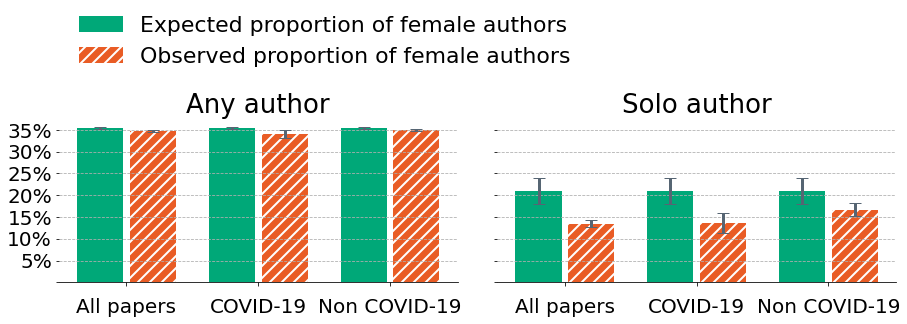

In [27]:
plot_types = ['Any', 'Solo']
#plot_types = ['First', 'Last']
plot_data = {'All publishers':{your_key: all_[your_key] for your_key in plot_types}}

mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(len(plot_data), 2, figsize=(15, len(plot_data)*3), sharey=True)

j = 0
for c, v in plot_data['All publishers'].items():

    x = np.array(range(0,len(v.keys())))

    expected = [v['expected']*100 for k,v in v.items()]
    ax[j].bar(x-0.2,expected, width=0.35, 
              align = 'center', color=colors['mygreen'],label='Expected proportion of female authors')

    real = [v['real']*100 for k,v in v.items()]
    ax[j].bar(x+0.2,real, width=0.35, 
              align = 'center', color=colors['myorange'], hatch="//", label='Observed proportion of female authors')

    expected_err = [v['expected_err']*100 for k,v in v.items()]
    ax[j].errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
    real_err = [v['real_err']*100 for k,v in v.items()]
    ax[j].errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

    ax[j].set_xticks(x)
    ax[j].tick_params(axis='x', which='major', pad=12)
    labels = ['All papers', 'COVID-19', 'Non COVID-19']

    ax[j].set_xticklabels(labels, fontsize=20)
    ax[j].set_title(c+' author', fontsize=26)

    ax[j].yaxis.grid(True, which='major', linestyle='--')
    ax[j].spines['top'].set_visible(False)
    ax[j].spines['right'].set_visible(False)
    ax[j].spines['left'].set_visible(False)
    if j == 0:

        ax[j].legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
        ax[j].set_yticklabels([''] + [str(int(x))+'%' for x in ax[j].get_yticks()][1:], size = 20)

    j+=1
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

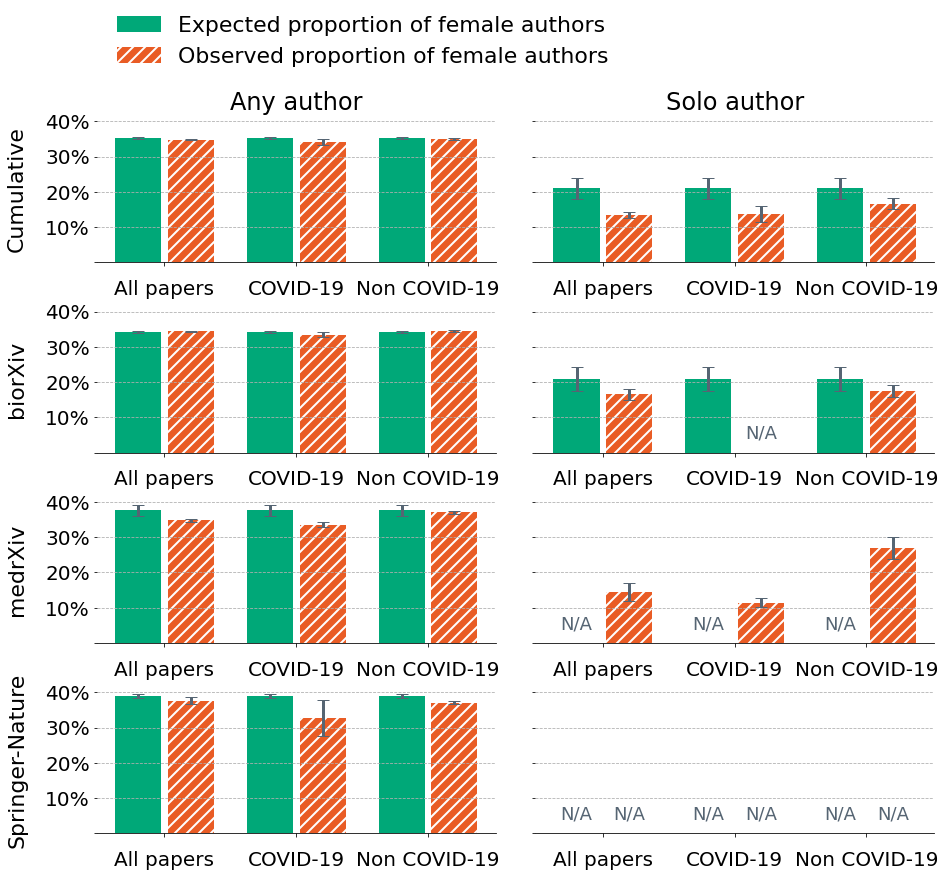

In [28]:
plot_data = {}
for k in everything.keys():
    dict_you_want = {your_key: everything[k][your_key] for your_key in plot_types}
    plot_data[k] = dict_you_want

#plot_data = everything
mpl.rcParams['hatch.linewidth'] = 2
mpl.rcParams['hatch.color'] = 'white'
fig, ax = plt.subplots(len(plot_data), 2, figsize=(15, len(plot_data)*3.3), sharey=True)

i = 0
for k, value in plot_data.items():
    j = 0
    for c, v in value.items():

        x = np.array(range(0,len(v.keys())))

        expected = [v['expected']*100 if not math.isnan(v['expected']) else 0 for k,v in v.items()]

        ax[i,j].bar(x-0.2,expected, width=0.35, 
                  align = 'center', color=colors['mygreen'],label='Expected proportion of female authors')

        real = [v['real']*100 if not math.isnan(v['real']) else 0 for k,v in v.items()]

        ax[i,j].bar(x+0.2,real, width=0.35, 
                  align = 'center', color=colors['myorange'], hatch="//", label='Observed proportion of female authors')
        for loc,value in zip(x,real):
            if value==0:
                ax[i,j].text(loc+0.2,4,'N/A',horizontalalignment='center', fontsize=18, color=colors['darkgrey'])
                
        for loc,value in zip(x,expected):
            if value==0:
                ax[i,j].text(loc-0.2,4,'N/A',horizontalalignment='center', fontsize=18, color=colors['darkgrey'])


        expected_err = [v['expected_err']*100 for k,v in v.items()]
        ax[i,j].errorbar(x-0.2, expected, yerr=expected_err, color='#566573', linewidth=3, ls='none',capsize=6)
        real_err = [v['real_err']*100 for k,v in v.items()]
        ax[i,j].errorbar(x+0.2, real, yerr=real_err, color='#566573', linewidth=3, ls='none',capsize=6)

        
        ax[i,j].set_xticks(x)
        ax[i,j].tick_params(axis='x', which='major', pad=14)
        labels = ['All papers', 'COVID-19', 'Non COVID-19']
        
        ax[i,j].set_xticklabels(labels, fontsize=20)
        if i==0:
            ax[i,j].set_title(c+' author', fontsize=24)
        
        ax[i,j].yaxis.grid(True, which='major', linestyle='--')
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        if j == 0:
            ax[i,j].set_ylabel(k, fontsize=22, labelpad=18)
            ax[i,j].set_yticklabels([''] + [str(int(x))+'%' for x in ax[i,j].get_yticks()][1:], size = 20)
            if i == 0:
                ax[i,j].legend(ncol=1, fontsize=22, frameon=False, loc='lower left', bbox_to_anchor=(0, 1.2))
            
        j+=1
    i+=1
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

### Gender differences across countries

In [37]:
def geo_plot(what,n,df,df1,df_last,df_single):
    big = df[df['date']>=split_date].groupby('country_code')['name'].count().sort_values(ascending=False).iloc[0:n].index
    if what == 'First':
        cc = df1[df1['country_code'].isin(big)]    
    if what == 'Last':
        cc = df_last[df_last['country_code'].isin(big)]
    if what == 'Any':
        cc = df[df['country_code'].isin(big)]
    if what == 'Solo':
        cc = df_single[df_single['country_code'].isin(big)]

    countries_all = {}
    countries_covid = {}
    countries_noncovid = {}
    G = cc.groupby('country_code')
    for name, group in G:
        c = gender_diff_frac(group,freq,split_date,gt_max_date, covid='all')
        countries_all[name]= {'value':((c[1]-c[0])/c[0])*100,'err':((c[2]+c[3])/c[0])*100, 'raw':c}

        cd = gender_diff_frac(group,freq,split_date,gt_max_date, covid=True)
        countries_covid[name]= {'value':((cd[1]-cd[0])/cd[0])*100,'err':((cd[2]+cd[3])/cd[0])*100, 'raw':cd}

        cn = gender_diff_frac(group,freq,split_date,gt_max_date, covid=False)
        countries_noncovid[name]= {'value':((cn[1]-cn[0])/cn[0])*100,'err':((cn[2]+cn[3])/cn[0])*100, 'raw':cn}

    data = {'All papers': countries_all, 'COVID-19': countries_covid, 'Non COVID-19': countries_noncovid}
    geo_data = data

    fig, ax = plt.subplots(1,3, figsize=(12, 4))
    i=0
    for name, d in data.items():
        countries_sort = OrderedDict(sorted(d.items(), key=lambda x: float('-inf') if math.isnan(x[1]['value']) else x[1]['value'], reverse=False))
        x = [v['value'] for v in countries_sort.values()]
        xerr = [v['err'] for v in countries_sort.values()]
        cols = [colors['myorange'] if v < 0 else colors['mygreen'] for v in x]

        y = range(0,len(countries_sort))
        for val, y_loc, err, col in zip(x,y,xerr,cols):
            if math.isnan(val):
                ax[i].errorbar(0, y_loc, xerr=err, fmt='o', markersize=0, capsize=6, linewidth=4, color=col)
            else:
                ax[i].errorbar(val, y_loc, xerr=err, fmt='o', markersize=10, capsize=6, linewidth=4, color=col)

        ax[i].set_yticks(range(0,len(countries_sort)))
        labels = countries_sort.keys()
        ax[i].set_yticklabels(labels, fontsize=18)
        ax[i].xaxis.grid(True, which='major', linestyle='--')
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].set_xlim(left=-50, right=50)
        ax[i].set_title(name, fontsize=24)
        ax[i].set_xticks([-50,-25,0,25,50], minor=False)
        ax[i].tick_params(axis='x', which='major', labelsize=18)
        ax[i].axvline(x=0, linewidth=4, linestyle='--', color=colors['darkgrey'])
        if i == 0:
            ax[i].set_ylabel(what + ' author', fontsize=22, labelpad=18)
        i+=1

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None)

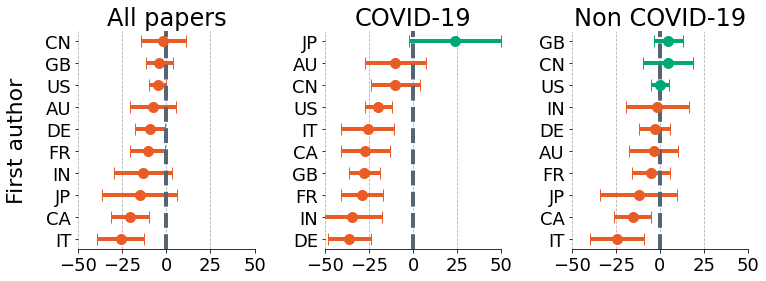

In [36]:
what = 'First'
n=10
geo_plot(what,n,df,df1,df_last,df_single)

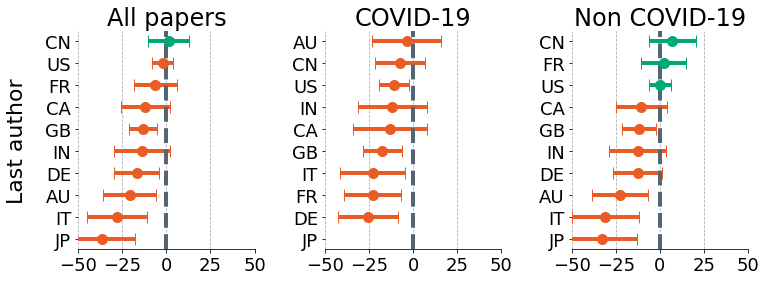

In [38]:
what = 'Last'
n=10
geo_plot(what,n,df,df1,df_last,df_single)

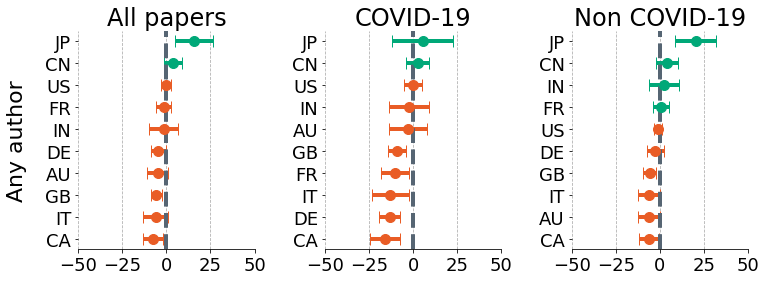

In [39]:
what = 'Any'
n=10
geo_plot(what,n,df,df1,df_last,df_single)

### GDP

In [40]:
n=16
big = df[df['date']>=split_date].groupby('country_code')['name'].count().sort_values(ascending=False).iloc[0:n].index
cc = df[df['country_code'].isin(big)]

countries_all = {}
countries_covid = {}
countries_noncovid = {}
G = cc.groupby('country_code')
for name, group in G:
    c = gender_diff_frac(group,freq,split_date,gt_max_date, covid='all')
    countries_all[name]= {'value':((c[1]-c[0])/c[0])*100,'err':((c[2]+c[3])/c[0])*100, 'raw':c}

    cd = gender_diff_frac(group,freq,split_date,gt_max_date, covid=True)
    countries_covid[name]= {'value':((cd[1]-cd[0])/cd[0])*100,'err':((cd[2]+cd[3])/cd[0])*100, 'raw':cd}

    cn = gender_diff_frac(group,freq,split_date,gt_max_date, covid=False)
    countries_noncovid[name]= {'value':((cn[1]-cn[0])/cn[0])*100,'err':((cn[2]+cn[3])/cn[0])*100, 'raw':cn}
    
data = {'All papers': countries_all, 'COVID-19': countries_covid, 'Non COVID-19': countries_noncovid}
geo_data = data

In [41]:
covid_data = pd.read_csv('data/owid-covid-data.csv')#, usecols=['location','total_cases_per_million', 'date'])
covid_data = covid_data[covid_data['date']==split_date].drop(columns=['date'])
covid_data['location'] = covid_data['location'].astype('str').str.lower()

In [42]:
countries_data = pd.read_csv('data/countries.csv')
countries_data['Name'] = countries_data['Name'].astype('str')
countries_data['Name'] = countries_data['Name'].replace('korea, republic of', 'south korea')
countries_data = countries_data.set_index('Name')
covid_data = covid_data.join(countries_data, on='location')
covid_data['location'] = covid_data['location'].str.title()

In [43]:
asia = ['Japan', 'South Korea', 'China', 'India', 'Singapore']

In [44]:
cc = df[df['country_code']!=np.nan]
cc = cc[(cc['country_code'].isin(big))&(cc['date']<=split_date)]
g = cc.groupby('country_code')

d = g.apply(f_fraction).to_frame().rename(columns={0:'frac_before'})
d2 = pd.DataFrame.from_dict(data['All papers'],orient='index').rename(columns={'value':'drop'})[['drop']]
cd = covid_data[covid_data['Code'].isin(d.index)]
cd = cd.join(d, on='Code').join(d2, on='Code')
cd['region'] = ['Asia' if x in asia else 'Europe and Americas' for x in cd['location']]
cd = cd[['location','gdp_per_capita','frac_before','drop','region']]
# replace South Korea with S. Korea
cd['location'] = cd['location'].str.replace('South Korea', 'S.Korea')
# replace United States with US
cd['location'] = cd['location'].str.replace('United States', 'US')

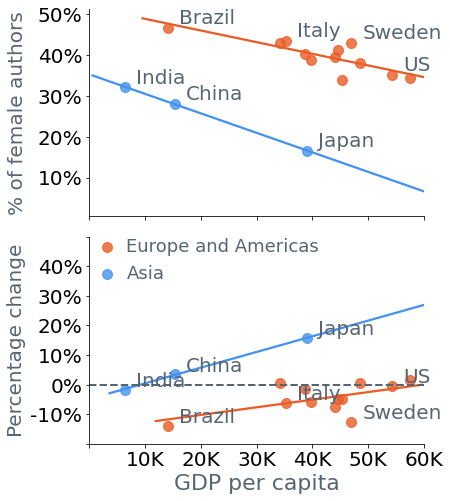

In [45]:
fig, ax = plt.subplots(2,1, figsize=(6, 8), sharex=True)
regions = ['Europe and Americas', 'Asia']
cols = [colors['myorange'], colors['myblue']]
for i in range(0,2):
    
    sns.regplot(y="drop", x="gdp_per_capita", data=cd[cd['region']==regions[i]], 
                ax=ax[1], ci=0, color=cols[i], label=regions[i], scatter_kws={"s": 100})
    sns.regplot(y="frac_before", x="gdp_per_capita", data=cd[cd['region']==regions[i]], 
                ax=ax[0], ci=0, color = cols[i], label = regions[i],scatter_kws={"s": 100})

show_names=['Brazil','India','China','S.Korea', 'Japan', 'US', 'Italy', 'Sweden']
for i in range(0,2):
    ax[i].set_xlabel('')
    ax[i].set_xlim(0,60000)
    
    
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    
    if i == 0:
        ax[i].set_ylabel("% of female authors", fontsize=20, color=colors['darkgrey'], labelpad=10)
        ax[i].set_yticklabels([''] + [str(int(round(x*100,1))) + '%' for x in ax[i].get_yticks()][1:], size = 20)
        for j, txt in enumerate(cd['location']):
            if txt in show_names:
                ax[i].annotate(txt, (cd['gdp_per_capita'].iloc[j]+2000, cd['frac_before'].iloc[j]+0.01),
                                 fontsize=20, horizontalalignment='left', color=colors['darkgrey'])
    if i == 1:
        ax[i].set_ylabel("Percentage change", fontsize=20, color=colors['darkgrey'])
        ax[i].set_yticklabels([''] + [str(int(round(x,0)))+'%' for x in ax[i].get_yticks()][1:], size = 20)
        ax[i].set_xticklabels([''] + [str(int(round(x/1000,0)))+'K' for x in ax[i].get_xticks()][1:], size = 20)
        ax[i].set_xlabel('GDP per capita', fontsize=22, color=colors['darkgrey'])
        ax[i].set_ylim(-20,50)
        ax[i].axhline(y=0, linewidth=2, linestyle='--', color=colors['darkgrey'])
        for j, txt in enumerate(cd['location']):
            if txt in show_names:
                ax[i].annotate(txt, (cd['gdp_per_capita'].iloc[j]+2000, cd['drop'].iloc[j]+1),
                                 fontsize=20, horizontalalignment='left', color=colors['darkgrey'])

    a = ax[1].legend(ncol=1, fontsize=18, frameon=False, loc='lower left', bbox_to_anchor=(-0.05, 0.7), handletextpad = 0.1)
    for text in a.get_texts():
        text.set_color(colors['darkgrey'])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)

# Tables

### Change DURING the pandemic

In [46]:
def during(what,platforms,df1,df_last,df,df_single,covid='all'):

    if what == 'First':
        pandemic = df1[(df1['date']>=split_date) & (df1['date']<=gt_max_date)]
    if what == 'Last':
        pandemic = df_last[(df_last['date']>=split_date) & (df_last['date']<=gt_max_date)]
    if what == 'Any':
        pandemic = df[(df['date']>=split_date) & (df['date']<=gt_max_date)]
    if what == 'Solo':
        pandemic = df_single[(df_single['date']>=split_date) & (df_single['date']<=gt_max_date)]
    
    if covid==True:
        pandemic = pandemic[pandemic['is_covid']==1]
    if covid==False:
        pandemic = pandemic[pandemic['is_covid']==0]


    placeholder = pd.Series(pd.date_range(start=split_date, end=gt_max_date, freq='W')).rename('date').to_frame().set_index('date')
    for platform in platforms:
        g = pandemic[pandemic['platform']==platform].groupby(pd.Grouper(key='date',freq='W'))
        n = g.apply(f_fraction)[:gt_max_date]
        placeholder = placeholder.join(n.rename(platform))

    g = pandemic.groupby(pd.Grouper(key='date',freq='W'))
    n = g.apply(f_fraction)[:gt_max_date]
    placeholder = placeholder.join(n.rename('All'))

    placeholder['id'] = range(0,len(placeholder))

    r = {}
    for platform in platforms + ['All']:
        try:
            Y_pre = placeholder[platform].dropna()
            X_pre = range(0,len(Y_pre))
            X_pre = sm.add_constant(X_pre)
            results_pre = sm.OLS(Y_pre,X_pre).fit()
            p_value = results_pre.pvalues['x1']
            r2 = results_pre.rsquared
            coef = results_pre.params['x1']
            r[platform] = {'p':p_value, 'coef':coef}
        except:
            r[platform] = {'p':np.nan, 'coef':np.nan}
    return(r)

In [47]:
res = pd.DataFrame(['biorXiv', 'medrXiv', 'Springer', 'All']).rename(columns={0:'platform'}).set_index('platform')
platforms = ['biorXiv', 'medrXiv', 'Springer']
for what in ['First','Last','Any','Solo']:
    r = during(what,platforms,df1,df_last,df,df_single, covid=True)
    r = pd.DataFrame.from_dict(r).T
    res = res.join(r, rsuffix=what)
res = res.rename(columns={'p':'pFirst','coef':'coefFirst'})

C:\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1620: RuntimeWarning:

divide by zero encountered in double_scalars



In [48]:
res = res.round(3).fillna('--')

In [49]:
res

,pFirst,coefFirst,pLast,coefLast,pAny,coefAny,pSolo,coefSolo
platform,,,,,,,,
biorXiv,0.449,-0.002,0.254,0.003,0.008,0.003,--,-0.167
medrXiv,0.002,0.004,0.000,0.004,0.000,0.005,0.058,-0.006
Springer,0.472,-0.037,0.443,0.025,0.185,0.027,--,--
All,0.332,0.001,0.000,0.003,0.000,0.005,0.11,-0.005


In [90]:
o = ['First','Last','Any','Solo']

a = pd.DataFrame()
for w in o:
    all_f = pd.DataFrame.from_dict(all_[w]).T.reset_index()
    all_f['order'] = w
    a = pd.concat([a,all_f])
a = a.rename(columns={
    'expected':'ar. mean', 'expected_err':'st. err',
    'p_value':'p value','real':'observed ar. mean',
    'real_err':'observed st. err','index':'papers'})
a['publisher'] = 'All publishers'


m = pd.DataFrame()
for w in o:
    med_f = pd.DataFrame.from_dict(medrxiv[w]).T.reset_index()
    med_f['order'] = w
    m = pd.concat([m,med_f])
m = m.rename(columns={
    'expected':'ar. mean', 'expected_err':'st. err',
    'p_value':'p value','real':'observed ar. mean',
    'real_err':'observed st. err','index':'papers'})
m['publisher'] = 'medrXiv'

b = pd.DataFrame()
for w in o:
    bio_f = pd.DataFrame.from_dict(biorxiv[w]).T.reset_index()
    bio_f['order'] = w
    b = pd.concat([b,bio_f])
b = b.rename(columns={
    'expected':'ar. mean', 'expected_err':'st. err',
    'p_value':'p value','real':'observed ar. mean',
    'real_err':'observed st. err','index':'papers'})
b['publisher'] = 'biorXiv'

s = pd.DataFrame()
for w in o:
    spr_f = pd.DataFrame.from_dict(springer[w]).T.reset_index()
    spr_f['order'] = w
    s = pd.concat([s,spr_f])
s = s.rename(columns={
    'expected':'ar. mean', 'expected_err':'st. err',
    'p_value':'p value','real':'observed ar. mean',
    'real_err':'observed st. err','index':'papers'})
s['publisher'] = 'Springer-Nature'

In [93]:
res = pd.concat([a,b,m,s])
res['papers'] = res['papers'].replace({'COVID':'COVID-19', 'nonCOVID':'Non COVID-19'})
res = res.set_index(['publisher','order','papers'])
res['% diff'] = ((res['ar. mean']-res['observed ar. mean'])/res['ar. mean'])*100
#res['std'] = res['st. err']
res = res.round(3).fillna('--')
res = res.drop(columns=['coef','r2','p value'])
res.insert(2, 'x', '')
res.insert(5, 'xx', '')

In [94]:
res

ar. mean observed ar. mean x st. err  \
publisher       order papers                                              
All publishers  First All             0.389             0.352     0.007   
                      COVID-19        0.389             0.279     0.007   
                      Non COVID-19    0.389             0.379     0.007   
                Last  All             0.257             0.236     0.005   
                      COVID-19        0.257             0.208     0.005   
                      Non COVID-19    0.257             0.245     0.005   
                Any   All             0.354             0.348     0.003   
                      COVID-19        0.354             0.341     0.003   
                      Non COVID-19    0.354              0.35     0.003   
                Solo  All              0.21             0.135      0.03   
                      COVID-19         0.21             0.136      0.03   
                      Non COVID-19     0.21             0.166      0.03   
biorXiv         First All             0.367              0.37     0.008   
                      COVID-19        0.367              0.32     0.008   
                      Non COVID-19    0.367             0.375     0.008   
                Last  All             0.235             0.233     0.007   
                      COVID-19        0.235             0.188     0.007   
                      Non COVID-19    0.235             0.238     0.007   
                Any   All             0.342             0.344     0.003   
                      COVID-19        0.342             0.334     0.003   
                      Non COVID-19    0.342             0.345     0.003   
                Solo  All             0.209             0.165     0.035   
                      COVID-19        0.209                --     0.035   
                      Non COVID-19    0.209             0.175     0.035   
medrXiv         First All             0.335               0.3     0.055   
                      COVID-19        0.335             0.258     0.055   
                      Non COVID-19    0.335             0.383     0.055   
                Last  All              0.31              0.23     0.038   
                      COVID-19         0.31             0.214     0.038   
                      Non COVID-19     0.31             0.267     0.038   
                Any   All             0.376             0.348     0.016   
                      COVID-19        0.376             0.336     0.016   
                      Non COVID-19    0.376             0.371     0.016   
                Solo  All                --             0.145        --   
                      COVID-19           --             0.114        --   
                      Non COVID-19       --             0.269        --   
Springer-Nature First All             0.458             0.439      0.01   
                      COVID-19        0.458             0.448      0.01   
                      Non COVID-19    0.458              0.44      0.01   
                Last  All             0.316             0.286     0.007   
                      COVID-19        0.316             0.241     0.007   
                      Non COVID-19    0.316              0.29     0.007   
                Any   All              0.39             0.377     0.005   
                      COVID-19         0.39             0.328     0.005   
                      Non COVID-19     0.39             0.371     0.005   
                Solo  All                --                --        --   
                      COVID-19           --                --        --   
                      Non COVID-19       --                --        --   

                                   observed st. err xx  % diff  
publisher       order papers                                    
All publishers  First All                     0.004      9.532  
                      COVID-19                0.007     28.394  
                      No

In [436]:
auth = pd.DataFrame.from_dict(numbers['authors']).T#.reset_index()
auth = auth.rename(columns={'expected':'total expected', 'expected_err':'total error','real':'total observed'})
auth = auth.drop(columns=['r2', 'coef', 'p'])
auth['% diff'] = ((auth['total observed']-auth['total expected'])/auth['total expected'])*100
auth = auth.round(3)
auth['total observed'] = auth['total observed'].astype(int)
auth.insert(2, 'x', '')

In [437]:
auth

,total expected,total observed,x,total error,real_err,% diff
All,124711.012,173176,,4459.474,232.630,38.862
Female,44182.109,60231,,1604.679,82.652,36.324
Male,80528.903,112945,,2897.390,152.644,40.254


In [439]:
pap = pd.DataFrame.from_dict(numbers['papers']).T#.reset_index()
pap = pap.rename(columns={'expected':'total expected', 'expected_err':'total error','real':'total observed'})
pap = pap.drop(columns=['r2', 'coef', 'p'])
pap['% diff'] = ((pap['total observed']-pap['total expected'])/pap['total expected'])*100
pap = pap.round(3)
pap['total observed'] = pap['total observed'].astype(int)
pap.insert(2, 'x', '')

In [440]:
pap

,total expected,total observed,x,total error,real_err,% diff
All,19706.087,25289,,658.846,32.308,28.331
medrXiv,2165.893,7244,,198.779,22.482,234.458
biorXiv,13156.660,16634,,495.626,22.691,26.430
Springer,1717.541,1413,,59.564,8.183,-17.731


In [50]:
# fraction of covid papers:
platforms = ['biorXiv', 'medrXiv', 'Springer']
for platform in platforms:
    print(platform)
    print(len(df[(df['platform']==platform) & (df['is_covid']==1)])/len(df[df['platform']==platform])*100)

biorXiv
4.3242308077542955
medrXiv
59.41299980362834
Springer
2.220038156905822


In [73]:
# stats per country
pap_c = df.groupby('country_code')['paper_id'].nunique().to_frame().rename(columns={'paper_id':'# papers'})
aut_c = df.groupby('country_code')['name'].nunique().to_frame().rename(columns={'name':'# authors'})
aut_c = aut_c.sort_values(by='# authors', ascending=False).head(30)
aut_c = aut_c.join(countries_data.reset_index().set_index('Code'))
aut_c['Name'] = aut_c['Name'].str.title()
aut_c = aut_c[['Name','# authors']]

In [76]:
aut_c

,Name,# authors
country_code,,
US,United States,111212
GB,United Kingdom,33386
CN,China,22381
DE,Germany,21919
FR,France,16846
CA,Canada,13037
JP,Japan,12413
AU,Australia,10603
IT,Italy,8961
